<a href="https://colab.research.google.com/github/wadaka0821/nlp-tutorial/blob/main/questions/2_9_semi_adder_question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなNN（ニューラルネットワーク）の実装

作成者：和田  
最終更新日：2023/02/25

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
seed = 42
# Pytorchのシード値を固定
# 必要に応じてpythonやnumpyなどのシード値も固定する必要があります（再現性を持たせたい場合）
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# 使用可能なデバイスの確認
f'{device=}'

"device='cpu'"

# 取り組むタスク

## 半加算器の動作をNNに学習させます

半加算器(2進数の足し算)の動作  

|入力1|入力2|出力1|出力2|  
|---:|---:|---:|---:|
|0|0|0|0|
|0|1|1|0|
|1|0|1|0|
|1|1|0|1|

※普通MLはルールベースの手法では対応が難しいような複雑なタスクに対して使用するべきなので，本来はこのタスクをNNに学習させるのは不適切ですが，練習なので分かりやすい例にしました

In [ ]:
# 入力用のテンソルを作成
x = torch.Tensor([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])

# 出力用のテンソルを作成
y = torch.Tensor([[0, 0],
                  [1, 0],
                  [1, 0],
                  [0, 1]])

[Text(0.5, 1.0, 'output2'), Text(0.5, 0, 'input1'), Text(0, 0.5, 'input2')]

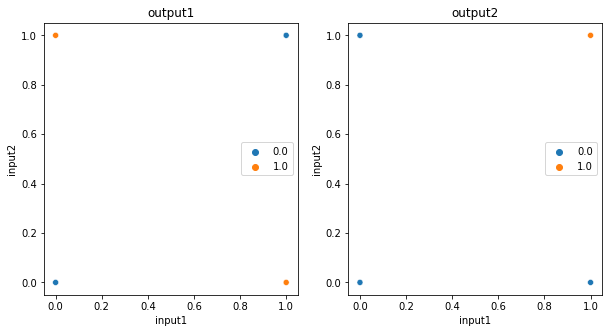

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y[:, 0], ax=ax[0]).set(title='output1', xlabel='input1', ylabel='input2')
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y[:, 1], ax=ax[1]).set(title='output2', xlabel='input1', ylabel='input2')

# モデルの定義と学習

In [ ]:
class SimpleNN(torch.nn.Module):
  def __init__(self, in_dim=2, hidden_dim=2, out_dim=2):
    super(SimpleNN, self).__init__()

    self.hidden_layer = torch.nn.Linear(in_features=in_dim, out_features=hidden_dim)
    self.output_layer = torch.nn.Linear(in_features=hidden_dim, out_features=out_dim)

  def forward(self, x):
    h = torch.relu(self.hidden_layer(x))
    y = torch.sigmoid(self.output_layer(h))

    return y

In [ ]:
MAX_EPOCH = 50
lr = 3e-2

model = SimpleNN(hidden_dim=5)
model.to(device)

x.to(device)
y.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
for epoch in range(1, MAX_EPOCH+1):
  optimizer.zero_grad(set_to_none=True)
  y_pred = model(x)
  loss = torch.mean(- (y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred)))

  loss.backward()
  optimizer.step()

  print(f'epoch : {epoch} | training loss : {loss.item():.3f}')

epoch : 1 | training loss : 0.662
epoch : 2 | training loss : 0.650
epoch : 3 | training loss : 0.639
epoch : 4 | training loss : 0.628
epoch : 5 | training loss : 0.616
epoch : 6 | training loss : 0.605
epoch : 7 | training loss : 0.598
epoch : 8 | training loss : 0.589
epoch : 9 | training loss : 0.582
epoch : 10 | training loss : 0.573
epoch : 11 | training loss : 0.564
epoch : 12 | training loss : 0.555
epoch : 13 | training loss : 0.545
epoch : 14 | training loss : 0.534
epoch : 15 | training loss : 0.521
epoch : 16 | training loss : 0.512
epoch : 17 | training loss : 0.502
epoch : 18 | training loss : 0.493
epoch : 19 | training loss : 0.482
epoch : 20 | training loss : 0.471
epoch : 21 | training loss : 0.460
epoch : 22 | training loss : 0.449
epoch : 23 | training loss : 0.438
epoch : 24 | training loss : 0.427
epoch : 25 | training loss : 0.416
epoch : 26 | training loss : 0.405
epoch : 27 | training loss : 0.394
epoch : 28 | training loss : 0.382
epoch : 29 | training loss : 

## 問題1
---
1. 今回作成したモデルでは sigmoid 関数を適用して出力としています．しかし，用途によっては必ずしも sigmoid 関数を適用する必要はありません．それはどのような場合でしょうか？
1. モデルに sigmoid 関数に適用する前の値(logits)を出力させる場合，損失の計算を変更する必要があります．このときに使用できる損失(torch.nnで定義されているもの)について調べてください．

 # 予測結果の確認

In [ ]:
with torch.no_grad():
  pred = model(x) > .5

In [ ]:
pred.int()

tensor([[0, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.int32)

In [ ]:
y

tensor([[0., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])

## 問題2
---
1. 今回，モデルの出力する確率が 0.5 を境界として 0, 1 を分けています．しかし，時には棄却域を設けて0, 1の判断を行わないことが適切である場合があります．それはどのような場合でしょうか？
1. 棄却域を設けた場合に，以下の指示に従って，正解率を計算するプログラムを書いてください
    - 棄却域は[0.3, 0.7]
    - 棄却されたものは正解率の計算から除外する
        - 正解を1, 誤りを0, 棄却されたものを-1としたときに[1, 1, 0, -1, 1, -1]の正解率は 0.75
    - 全体の内，棄却されたものの割合も計算する
    - モデルの予測結果と教師データは以下のコードで疑似的に作成する
    ```python
    # 予測結果の作成
    pred_Y = torch.rand((100, ))
    # 教師データの作成
    Y = torch.rand((100, )) > 0.5
    Y = Y.long()
    ```

# ネットワークの可視化（おまけ）

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchviz import make_dot

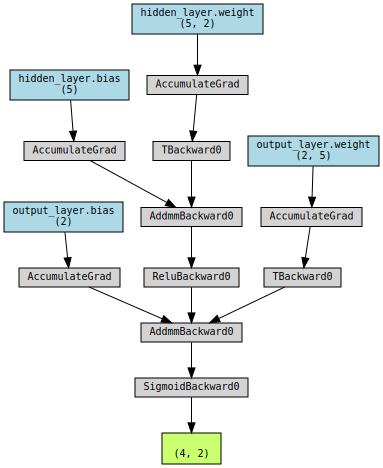

In [ ]:
model.zero_grad()
pred = model(x)
make_dot(pred, params=dict(list(model.named_parameters())))